In [288]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix
from pyarrow.feather import read_feather
import matplotlib.pyplot as plt
import pandas as pd
import sys
import sklearn
import numpy as np
import xlsxwriter

%matplotlib inline

In [38]:
sys.path.append("F:\Valentina\Experiments\exp_lookback\mylib")
import cv_toolkit as mycv

In [251]:
def get_cols(df, stem):
    return [col for col in list(df) if stem in col]

def cut_lookback(x, max_days):
    return x.where(x <= max_days, np.nan)

def cut_df(df, yrs):
    df_tmp = df.copy()
    for col in list(df):
        df_tmp[col] = cut_lookback(df_tmp[col], 365*yrs)
    return df_tmp

def cv_imp_feature(cv_outputs, f_cols):
    feature_imp = pd.DataFrame()
    feature_imp['Feature'] = f_cols
    for i in range(len(cv_outputs['models'])):  
        col = 'Fold_' + str(i)
        feature_imp[col] = cv_outputs['models'][i].feature_importances_
    feature_imp['Mean_score'] = feature_imp.iloc[:,1:].mean(axis=1)
    feature_imp.sort_values(by= 'Mean_score', axis = 0, ascending = False, inplace =True)
    feature_imp = feature_imp.reset_index(drop = True)
    return feature_imp

In [3]:
#set parameters
filename = "F:\\Valentina\\Experiments\\exp_lookback\\extra_data\\st_combined_train_unmatched_test_capped_freq_datediff_alldays.feather"
last_exp_stem = 'LAST_EXP_'
label = "label"
pos_label = 1
neg_label = 0

In [60]:
#select columns from dataset
df = read_feather(filename)
exp_cols = get_cols(df, last_exp_stem)
cols = exp_cols + [label]
df = df[cols]

In [61]:
#set 1:50 ratio
ratio = 50
n_pos = df[df[label] == pos_label].shape[0]
n_neg = df[df[label] == neg_label].shape[0]
n_sample_neg = n_pos *ratio
sampled_neg = df[df[label] == neg_label].sample(n= n_sample_neg, random_state = 2)
sampled_df = pd.concat([df[df[label] == pos_label], sampled_neg])
sampled_df = sampled_df.reset_index(drop=True)

In [15]:
print(n_pos, n_neg, n_pos*50, n_pos +n_pos*50)

1553 1628335 77650 79203


In [17]:
print(sampled_df.shape)

(79203, 342)


In [ ]:
#using sklearn methods
model = XGBClassifier
kfold = KFold(n_splits = 5, random_state = 7, shuffle = True)
results = cross_val_score(estimator = model,
                          X = sampled_df[exp_cols], 
                          y = sampled_df[label], 
                          cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [112]:
#using Shaun library for cv
#model = XGBClassifier(n_estimators = 50)
model = XGBClassifier
kfold = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
cv_outputs = mycv.run_CV(X = sampled_df[exp_cols], 
                         y = sampled_df[label], 
                         clf_class = model,
                         cv_method=kfold,
                         flatten=True)

In [113]:
eval_metrics = [precision_recall_curve, accuracy_score, confusion_matrix]
output_metrics ={}
output_metrics['All'] = mycv.calc_CV_metrics(**cv_outputs['predictions']['test'],
                                            metrics=eval_metrics, models=cv_outputs['models'],
                                            feature_names=exp_cols)


Text(0,0.5,'Precision')

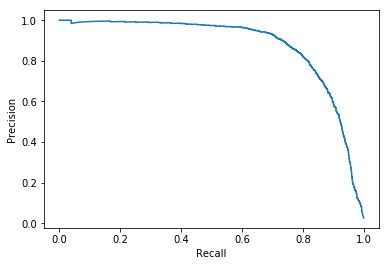

In [114]:
pd.DataFrame.from_dict(output_metrics['All']['precision_recall_curve']).plot(x='recall', y='precision', legend=False)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [147]:
feature_imp.head()

,Feature,Score
0,D_4010_LAST_EXP_DT,0.097523
1,D_2768_LAST_EXP_DT,0.061920
2,G_797000_LAST_EXP_DT,0.052632
3,S_S44_LAST_EXP_,0.041796
4,G_371000_LAST_EXP_DT,0.040248


## Running models on different lookback cut offs

In [184]:
#performing loop on different selection of features
output_metrics ={}
feature_imp = {}
model = XGBClassifier
kfold = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
#params = {'n_estimators': 50}
model_features = {'ALL': 5, '2 yrs': 2, '1yr': 1, '6 mo': 0.5, '3 mo': 0.25, '1 d': 1/365 }

for model_name, looklength in model_features.items():
    print(model_name)
    print("Computing dataframe...")
    modelling_data = cut_df(sampled_df, looklength)
    print("Running crossvalidation...")
    cv_outputs = mycv.run_CV(X = modelling_data[exp_cols], 
                         y = modelling_data[label], 
                         clf_class = model,
                         cv_method=kfold,
                         flatten=True)
    print("Computing metrics...")
    output_metrics[model_name] = mycv.calc_CV_metrics(**cv_outputs['predictions']['test'],
                                            metrics=eval_metrics, models=cv_outputs['models'],
                                            feature_names=exp_cols)
    print("Computing feature importance...")
    feature_imp[model_name] = cv_imp_feature(cv_outputs, exp_cols)


ALL
Computing dataframe...
Running crossvalidation...
Computing metrics...
Computing feature importance...
2 yrs
Computing dataframe...
Running crossvalidation...
Computing metrics...
Computing feature importance...
1yr
Computing dataframe...
Running crossvalidation...
Computing metrics...
Computing feature importance...
6 mo
Computing dataframe...
Running crossvalidation...
Computing metrics...
Computing feature importance...
3mo
Computing dataframe...
Running crossvalidation...
Computing metrics...
Computing feature importance...
1day
Computing dataframe...
Running crossvalidation...
Computing metrics...
Computing feature importance...


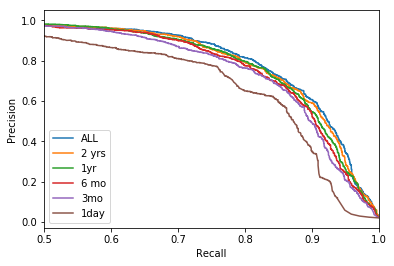

In [185]:
for model in output_metrics.keys():
    pr = pd.DataFrame.from_dict(output_metrics[model]['precision_recall_curve'])
    plt.plot(pr['recall'], pr['precision'], label = model)

plt.xlim(0.5,1.0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Running the model using only date differences ON the index date

In [226]:
#few predictors happen only on the index date
(modelling_data[exp_cols].isnull().sum() == 79203).sum()

4

In [229]:
exclude_cols = []
for col in list(modelling_data[exp_cols]):
    if modelling_data[col].isnull().sum() == 79203: exclude_cols.append(col)

In [252]:
#4 stems happens only on the index date
#1 label put to nan by previous code
model_name = 'ID only'
cols_1D = list(set(exp_cols) - set(exclude_cols))  
kfold = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
model = XGBClassifier
print("Computing dataframe...")
y = sampled_df[label]
modelling_data = cut_df(sampled_df[cols_1D], 0.9/365)
print("Running crossvalidation...")
cv_outputs = mycv.run_CV(X = modelling_data, 
                     y = y, 
                     clf_class = model,
                     cv_method=kfold,
                     flatten=True)
print("Computing metrics...")
output_metrics[model_name] = mycv.calc_CV_metrics(**cv_outputs['predictions']['test'],
                                        metrics=eval_metrics, models=cv_outputs['models'],
                                        feature_names=cols_1D)
print("Computing feature importance...")
feature_imp[model_name] = cv_imp_feature(cv_outputs, cols_1D)

Computing dataframe...
Running crossvalidation...
Computing metrics...
Computing feature importance...


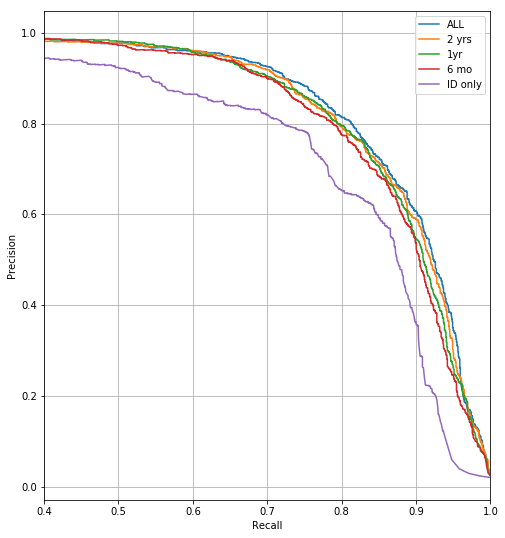

In [265]:
#model that includes only index date events is 15-20% worse than the full model
#model that includes only events in the last 6 months is about 5% worse
plt.figure(figsize = (8,9))
for model in ['ALL', '2 yrs', '1yr', '6 mo', 'ID only']:
    pr = pd.DataFrame.from_dict(output_metrics[model]['precision_recall_curve'])
    plt.plot(pr['recall'], pr['precision'], label = model)

plt.grid()
plt.xlim(0.4,1.0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [284]:
set(feature_imp['ALL'].head(10)['Feature']) - set(feature_imp['6 mo'].head(10)['Feature'])

set()

In [285]:
#the top predictors are slightly different when including only the index date
set(feature_imp['6 mo'].head(10)['Feature']) - set(feature_imp['ID only'].head(10)['Feature'])

{'G_371000_LAST_EXP_DT', 'G_797000_LAST_EXP_DT'}

In [296]:
workbook = pd.ExcelWriter('Strongbridge.xlsx', engine = 'xlsxwriter')
for model in ['ALL', '2 yrs', '1yr', '6 mo', 'ID only']:
    pr =  pd.DataFrame.from_dict(output_metrics[model]['precision_recall_curve']).sort_values(by='recall')
    pr.iloc[::50, :].to_excel(workbook, sheet_name= model)
workbook.save()